<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForest</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>RandomForest</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install scikit-learn==1.1.3

## Подготовка

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import lightgbm as lgbm
import catboost as cb
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv')

In [4]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.sort_index(inplace=True)

In [7]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

In [8]:
df.index.is_monotonic

True

Выполним ресемплирование по одному часу:

In [9]:
df = df.resample('1H').sum()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Мы загрузили данные и выполнили их ресемплирование по одному часу, перейдём к анализу

## Анализ

Для начала посмотрим на данные, в разрезе месяцов, дней и часов

<AxesSubplot:xlabel='datetime'>

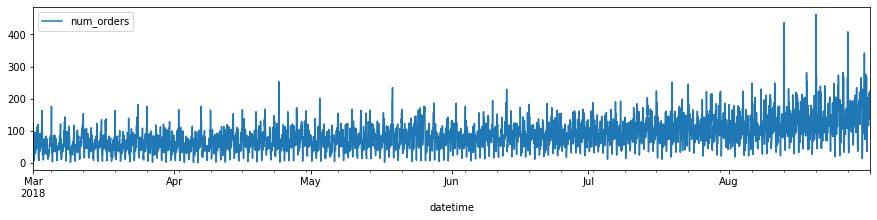

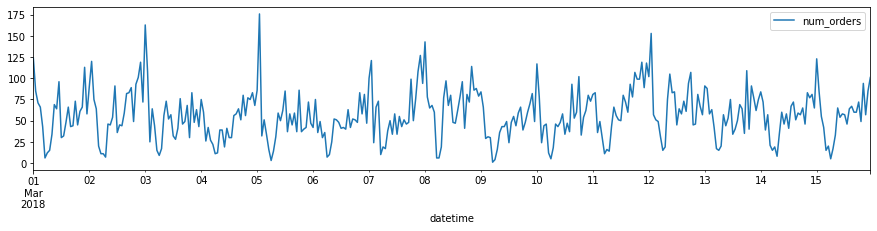

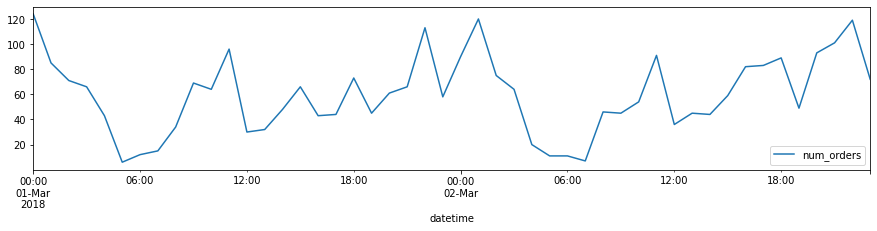

In [11]:
figsize=(15, 3)
df.plot(figsize=figsize)
df['2018-03-01':'2018-03-15'].plot(figsize=figsize)
df['2018-03-01':'2018-03-02'].plot(figsize=(15, 3))

Рассмотрим тернды, сезонность, остаток декомпозиции заказа такси

In [12]:
decomposed = seasonal_decompose(df)

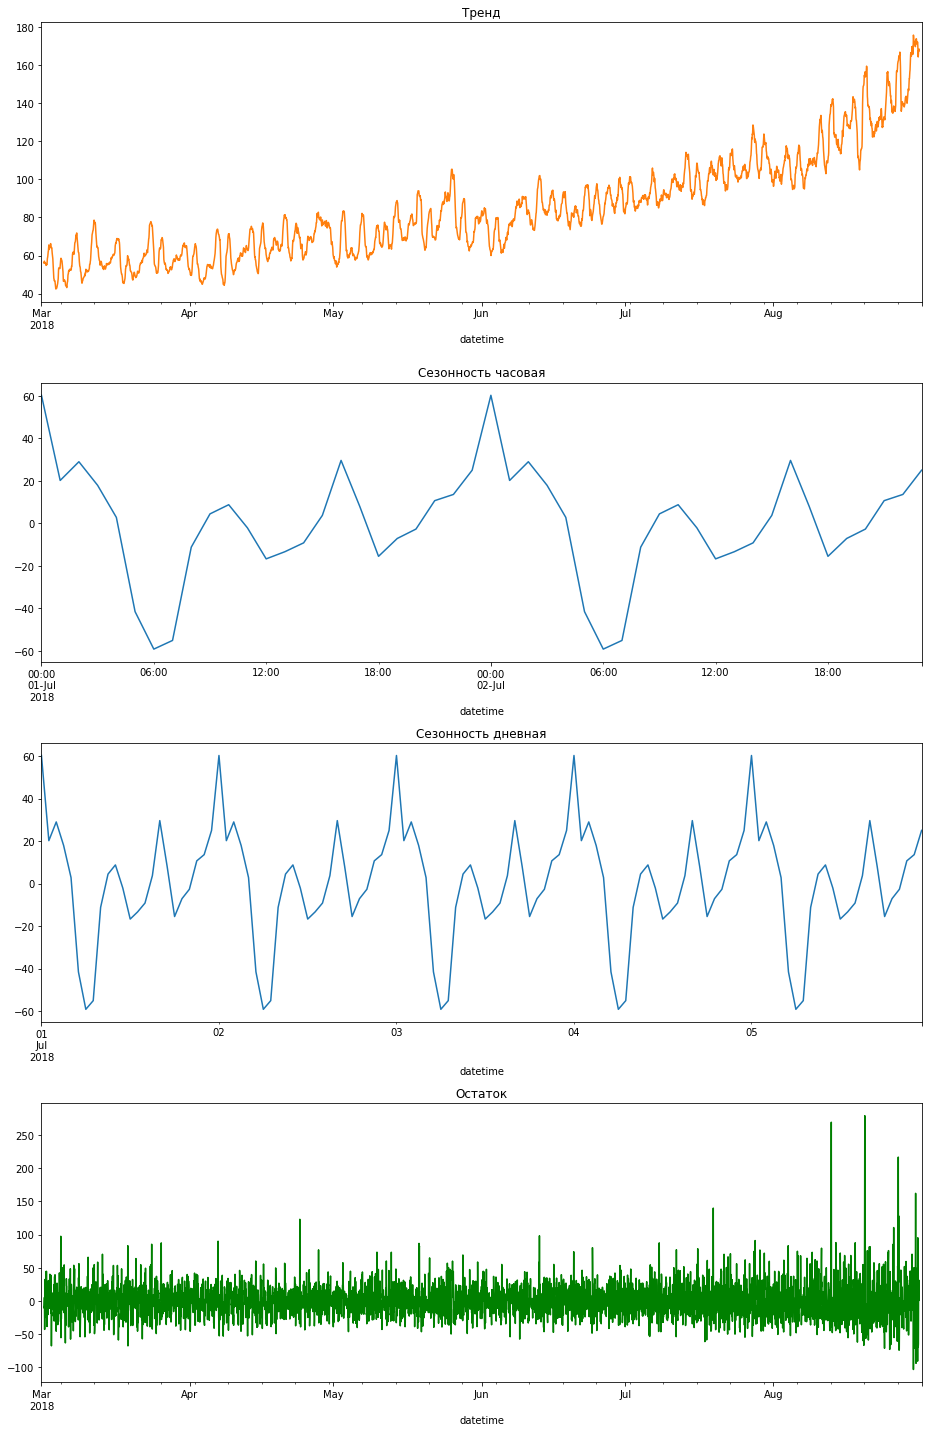

In [13]:
plt.figure(figsize=(13, 20))

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca(), color="C1")
plt.title('Тренд')

plt.subplot(412)
decomposed.seasonal['2018-07-01':'2018-07-02'].plot(ax=plt.gca())

plt.title('Сезонность часовая')

plt.subplot(413)
decomposed.seasonal['2018-07-01':'2018-07-05'].plot(ax=plt.gca())

plt.title('Сезонность дневная')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca(), color="g")
plt.title('Остаток')
plt.tight_layout()

plt.show()

In [14]:
df[df['num_orders'] > 300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


Видим очень большое количество вызовов такси в ночное время

Добавим скользящее среднее на график

Text(0.5, 1.0, 'Скользящее среднее')

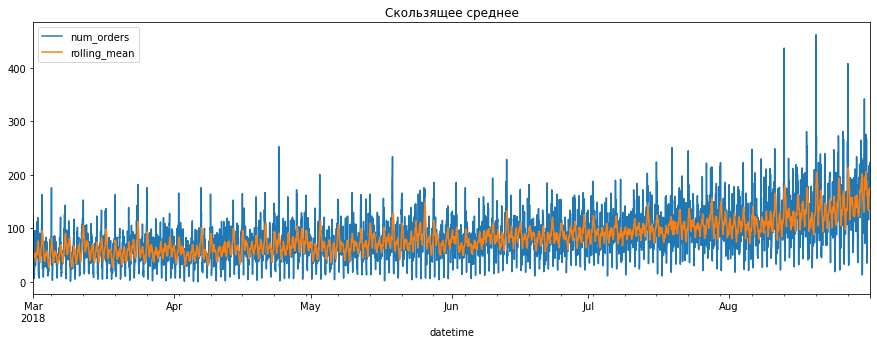

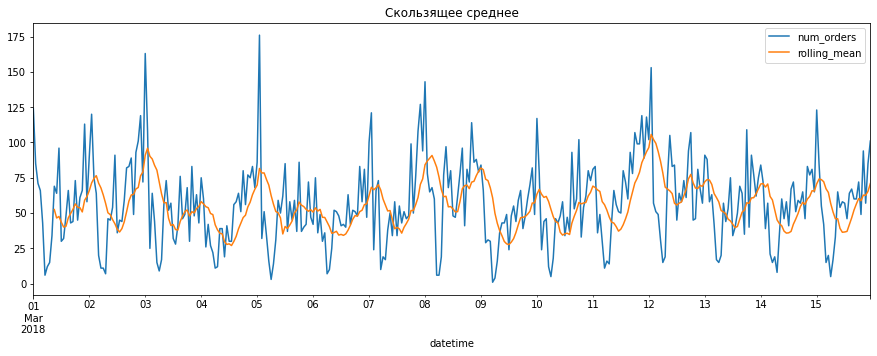

In [15]:
figsize=(15, 5)
df['rolling_mean'] = df.rolling(10).mean()
df.plot(figsize=figsize)
plt.title('Скользящее среднее')
df['2018-03-01':'2018-03-15'].plot(figsize=figsize)
plt.title('Скользящее среднее')

Вывод: 

Из данных можно видеть, что количество заказов растёт в фирме "Чёткое такси", рассчитав декомпозицию тренд подтверждает это. 

Сезонность также присутствует и она показывает на скачки спроса в полночь, около 00 часов, это время, когда общественный транспорт уже не ходит, люди гуляют, возвращаются домой, поздние рейсы, и тд.... Мы видим плавное увеличение спроса такси приближаясь к летнему периоду, но утверждать не можем о сезонности в зависимости от сезона, так как у нас данные всего пол года. 

Раз в данных присутствует тренд и сезонность, следовательно у нас не стационарный временной ряд.

Чтобы ряд сделать стационарным, найдём разности его значений.

<AxesSubplot:xlabel='datetime'>

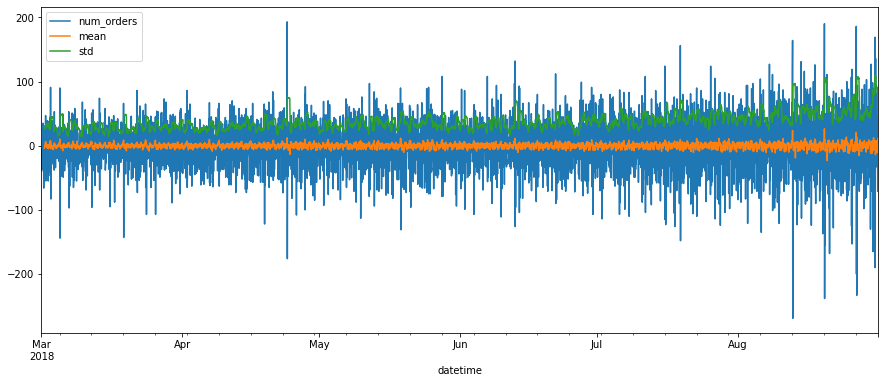

In [16]:
df_shift = df-df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(15).mean()
df_shift['std'] = df_shift['num_orders'].rolling(15).std()


df_shift[['num_orders', 'mean', 'std']].plot(figsize=(15, 6))

In [17]:
df.drop(['rolling_mean'], axis=1)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [18]:
def make_features(df, max_lag, rolling_mean_size):
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


Установим значение максимального размера отставания  скользящего среднего

In [19]:
make_features(df, 1,  24)

In [20]:
df.head(5)

,num_orders,rolling_mean,hour,dayofweek,lag_1
datetime,,,,,
2018-03-01 00:00:00,124,NaN,0,3,NaN
2018-03-01 01:00:00,85,NaN,1,3,124.0
2018-03-01 02:00:00,71,NaN,2,3,85.0
2018-03-01 03:00:00,66,NaN,3,3,71.0
2018-03-01 04:00:00,43,NaN,4,3,66.0


Приступим к обучению моделей

## Обучение

In [21]:
train,  test = train_test_split(df, shuffle=False, test_size=0.1)

In [22]:
train = train.dropna()

In [23]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

In [24]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [25]:
features_train.shape, features_test.shape

((3950, 4), (442, 4))

Данные разделили на обучающую, валидационную и тестовую, для проверки выбранной модели. Обучим линейную модель Ridge, CatBoost, LightGBM, RandomForest

Посмотрим до начала обучения моделей на среднее количество заказов в день и RMSE на тесте

In [26]:
print("Среднее количество заказов в день:", test['num_orders'].mean())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE:", mean_squared_error(test, pred_previous)**0.5)

Среднее количество заказов в день: 139.55656108597285
RMSE: 37.30270955796324


Данные не нуждаются в кодировании и масштабировании, перейдём сразу к обучению линейной модели

### Линейная регрессия

In [27]:
start = time.time()

splits = TimeSeriesSplit(n_splits=8).split(features_train)
linear = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
start_2 = time.time()
linear.fit(features_train, target_train)
end_2 = time.time()

RMSE_linear_train = pd.Series(cross_val_score(linear, features_train, target_train, 
                                              scoring='neg_root_mean_squared_error', cv=splits)).mean()*(-1)
end = time.time()
linear_fit = end_2 - start_2
print('Время подбора параметров c обучением: ', end - start)
print('Время обучениия: ', linear_fit)
    
print('RMSE: ', RMSE_linear_train)

Время подбора параметров c обучением:  0.05115222930908203
Время обучениия:  0.00434565544128418
RMSE:  31.366763577025026


In [28]:
result_linear_fit = pd.DataFrame([linear_fit, RMSE_linear_train], 
                             index=['Среднее время обучения, сек.', 'RMSE на train'], 
                             columns=['RMSE_Linear'])
result_linear_fit

,RMSE_Linear
"Среднее время обучения, сек.",0.004346
RMSE на train,31.366764


### CatBoost

In [29]:
start = time.time()

splits = TimeSeriesSplit(n_splits=3)

cat = cb.CatBoostRegressor()

params_grid_cat = {'iterations': [250], 'learning_rate' : [0.1, 0.2], 'max_depth': [2, 4, 6, 10, 20],
                   'random_state':[42],'verbose':[False]}

cat_grid =  GridSearchCV(cat, params_grid_cat, scoring='neg_root_mean_squared_error', cv=splits) 
cat_grid.fit(features_train, target_train)

end = time.time()

print('Время подбора параметров c обучением: ', end - start)


params_cat = cat_grid.best_params_
cat_score = cat_grid.score(features_train, target_train) * (-1)

print('Оптимальные параметры: ', params_cat)
print('Качество модели  CatBoost: ', cat_score)

Время подбора параметров c обучением:  26.565308570861816
Оптимальные параметры:  {'iterations': 250, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 42, 'verbose': False}
Качество модели  CatBoost:  18.245431222670383


In [30]:
print(cat_grid.cv_results_['mean_fit_time'][2])

cat_grid.cv_results_['mean_score_time'][2]

0.7816620667775472


0.001804033915201823

In [31]:
result_cat_fit = pd.DataFrame([cat_grid.cv_results_['mean_fit_time'][2], cat_score], 
    index=['Среднее время обучения, сек.','RMSE на train'], 
    columns=['CatBoost']
)

result_cat_fit

,CatBoost
"Среднее время обучения, сек.",0.781662
RMSE на train,18.245431


### LightGBM

In [32]:
start = time.time()

splits = TimeSeriesSplit(n_splits=3)

light = lgbm.sklearn.LGBMRegressor()

params_grid_light = {'num_leaves': [5, 10, 15], 'num_iterations': [5,25,30], 
                     'max_depth': [2, 6, 8],'learning_rate':[0.1, 0.2]}

light_grid = GridSearchCV(light, params_grid_light, scoring='neg_root_mean_squared_error', cv=splits, n_jobs=-1)
light_grid.fit(features_train, target_train)

end = time.time()
print('Время подбора параметров c обучением: ', end - start)

params_light = light_grid.best_params_
light_score = light_grid.score(features_train, target_train) * (-1)

print('Оптимальные параметры: ', params_light)
print('Качество модели LightGBM: ', light_score)

Время подбора параметров c обучением:  19.91601586341858
Оптимальные параметры:  {'learning_rate': 0.2, 'max_depth': 8, 'num_iterations': 30, 'num_leaves': 15}
Качество модели LightGBM:  20.509385233048516


In [33]:
print(light_grid.cv_results_['mean_fit_time'][2])

light_grid.cv_results_['mean_score_time'][2]

0.034120400746663414


0.028674999872843426

In [34]:
result_light_fit = pd.DataFrame([light_grid.cv_results_['mean_fit_time'][2], light_score], 
    index=['Среднее время обучения, сек.', 'RMSE на train'], 
    columns=['LightGBM']
)

result_light_fit

,LightGBM
"Среднее время обучения, сек.",0.034120
RMSE на train,20.509385


### RandomForest

In [35]:
start = time.time()

splits = TimeSeriesSplit(n_splits=3)

model_forest = RandomForestRegressor(random_state=42)

params_grid_forest = {'n_estimators': range(5, 20, 5), 'max_depth': range(1, 10, 2), 
                 'min_samples_leaf': range(1, 5),'min_samples_split': range(2, 10, 2)}


forest_grid = GridSearchCV(model_forest, params_grid_forest, scoring='neg_root_mean_squared_error', cv=splits)
forest_grid.fit(features_train, target_train)

end = time.time()
print('Время подбора параметров c обучением: ', end - start)

params_forest = forest_grid.best_params_
forest_score = forest_grid.best_score_ * -1
print('Оптимальные параметры: ', params_forest)
print('Качество модели Forest: ', forest_score)

Время подбора параметров c обучением:  19.150628328323364
Оптимальные параметры:  {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 15}
Качество модели Forest:  27.899592260892806


In [36]:
print(forest_grid.cv_results_['mean_fit_time'][2])

forest_grid.cv_results_['mean_score_time'][2]

0.021058956782023113


0.0035430590311686196

In [37]:
result_forest_fit = pd.DataFrame([forest_grid.cv_results_['mean_fit_time'][2],forest_score,], 
    index=['Среднее время обучения, сек.', 'RMSE на train'], 
    columns=['RandomForest']
)

result_forest_fit

,RandomForest
"Среднее время обучения, сек.",0.021059
RMSE на train,27.899592


**РЕЗУЛЬТАТЫ ОБУЧЕНИЯ И ПРЕДСКАЗАНИЙ МОДЕЛЕЙ**

In [38]:
result_linear_fit.join([result_forest_fit, result_cat_fit, result_light_fit])

,RMSE_Linear,RandomForest,CatBoost,LightGBM
"Среднее время обучения, сек.",0.004346,0.021059,0.781662,0.034120
RMSE на train,31.366764,27.899592,18.245431,20.509385


Вывод: Данные были разделены на обучающую, валидационную тестовую выборки. Было проведено обучение моделей и найдены лучшие параметры для моделей: линейной регрессии, RandomForest, CatBoost и LightGBM

## Тестирование

### Линейная регрессия

In [39]:
start = time.time()

predict_linear_test = linear.predict(features_test)

end = time.time()
linear_pred = end - start
RMSE_linear_test = mean_squared_error(target_test, predict_linear_test)**0.5

print('Время обучения: ', linear_pred)
print('RMSE:  ', RMSE_linear_test) 

Время обучения:  0.002317190170288086
RMSE:   51.194080671652486


In [40]:
result_linear = pd.DataFrame([linear_fit, linear_pred, RMSE_linear_train, RMSE_linear_test], 
                             index=['Среднее время обучения, сек.', 'Время предсказания сек.', 'RMSE на train', 'RMSE на test'], 
                             columns=['RMSE_Linear'])
result_linear

,RMSE_Linear
"Среднее время обучения, сек.",0.004346
Время предсказания сек.,0.002317
RMSE на train,31.366764
RMSE на test,51.194081


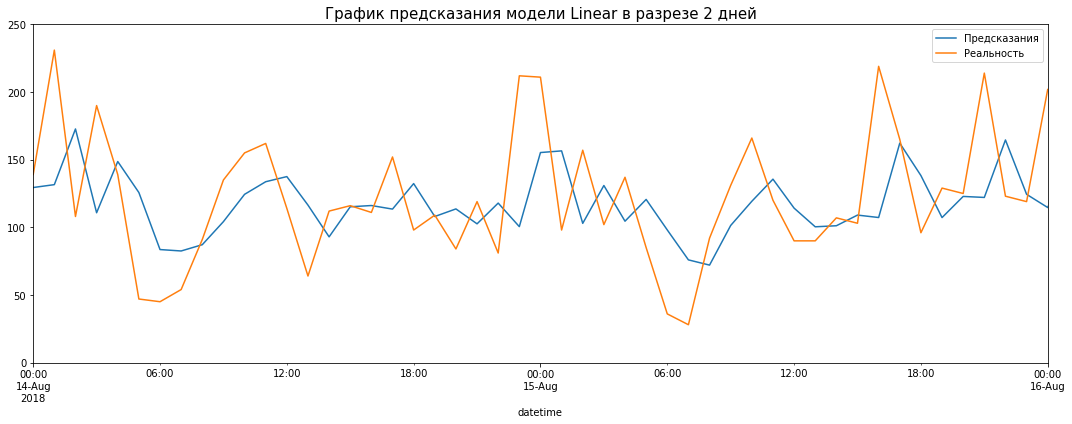

In [41]:
RMSE_linear_test = pd.Series(linear.predict(features_test), index = target_test.index)
plt.figure(figsize=(15, 6))

plt.title('График предсказания модели Linear в разрезе 2 дней', fontsize=15)
RMSE_linear_test.plot(label = 'Предсказания')
target_test.plot(label = 'Реальность')
plt.xlim(['2018-08-14','2018-08-16'])
plt.ylim([0, 250])
plt.legend()
plt.tight_layout()


### CatBoost

In [42]:
start = time.time()

predict_cat = cat_grid.predict(features_test)

end = time.time()
time_pred_cat = end - start
print('Время обучения: ', time_pred_cat)

RMSE_cat_test = mean_squared_error(target_test, predict_cat)**0.5
print('RMSE:  ', RMSE_cat_test)

Время обучения:  0.0019948482513427734
RMSE:   43.77637001394644


In [43]:
result_cat = pd.DataFrame([cat_grid.cv_results_['mean_fit_time'][2],time_pred_cat, cat_score,  RMSE_cat_test], 
    index=['Среднее время обучения, сек.', 'Время предсказания сек.', 'RMSE на train', 'RMSE на test'], 
    columns=['CatBoost']
)

result_cat

,CatBoost
"Среднее время обучения, сек.",0.781662
Время предсказания сек.,0.001995
RMSE на train,18.245431
RMSE на test,43.776370


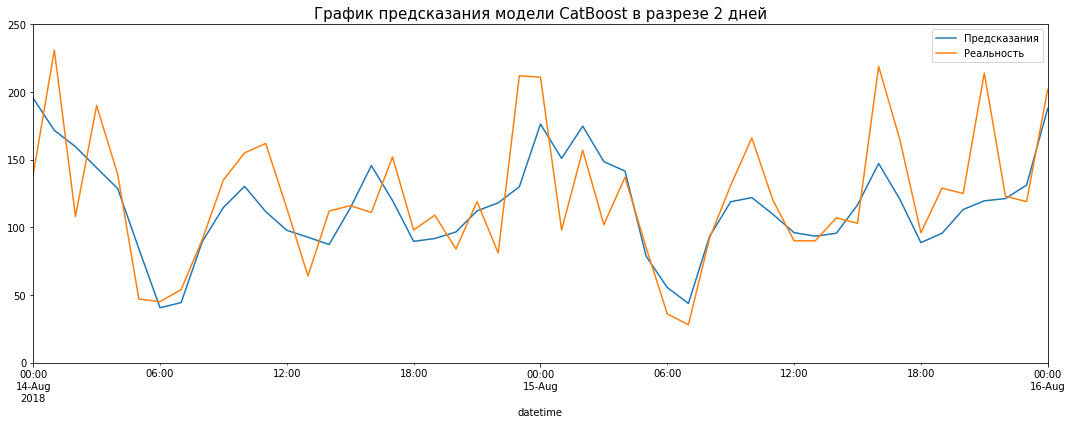

In [44]:
RMSE_cat_test = pd.Series(cat_grid.predict(features_test), index = target_test.index)
plt.figure(figsize=(15, 6))

plt.title('График предсказания модели CatBoost в разрезе 2 дней', fontsize=15)
RMSE_cat_test.plot(label = 'Предсказания')
target_test.plot(label = 'Реальность')
plt.xlim(['2018-08-14','2018-08-16'])
plt.ylim([0, 250])
plt.legend()
plt.tight_layout()


### LightGBM

In [45]:
start = time.time()

predict_light = light_grid.predict(features_test)

end = time.time()
time_pred_light = end - start
print(time_pred_light)

RMSE_light = mean_squared_error(target_test, predict_light)**0.5

print('RMSE:  ', RMSE_light)

0.004438161849975586
RMSE:   45.20784398177665


In [46]:
result_light = pd.DataFrame([light_grid.cv_results_['mean_fit_time'][2], time_pred_light, light_score, RMSE_light], 
    index=['Среднее время обучения, сек.', 'Время предсказания сек.', 'RMSE на train', 'RMSE на test'], 
    columns=['LightGBM']
)

result_light

,LightGBM
"Среднее время обучения, сек.",0.034120
Время предсказания сек.,0.004438
RMSE на train,20.509385
RMSE на test,45.207844


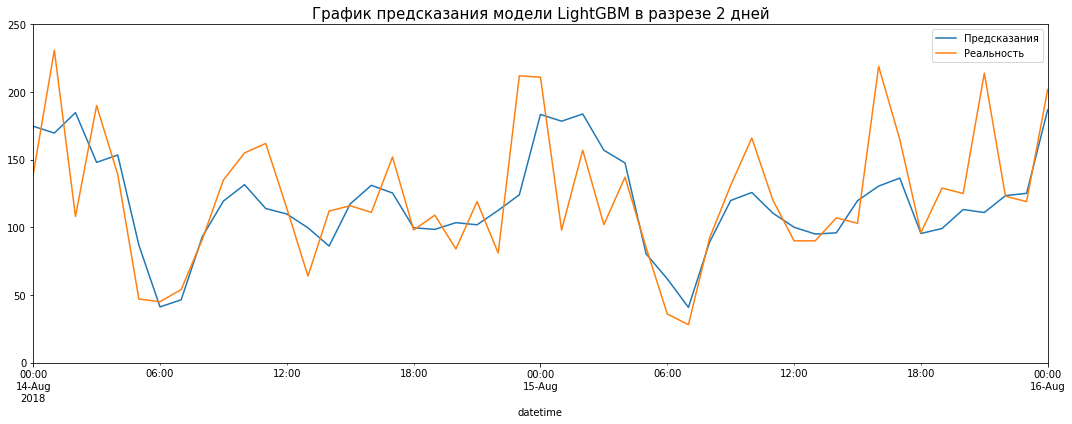

In [47]:
RMSE_light = pd.Series(light_grid.predict(features_test), index = target_test.index)
plt.figure(figsize=(15, 6))

plt.title('График предсказания модели LightGBM в разрезе 2 дней', fontsize=15)
RMSE_light.plot(label = 'Предсказания')
target_test.plot(label = 'Реальность')
plt.xlim(['2018-08-14','2018-08-16'])
plt.ylim([0, 250])
plt.legend()
plt.tight_layout()


### RandomForest

In [48]:
start = time.time()

predict_forest = forest_grid.predict(features_test)

end = time.time()
time_pred_forest = end - start
print(time_pred_forest)


MAE_forest=mean_absolute_error(target_test, predict_forest)
RMSE_forest = mean_squared_error(target_test, predict_forest)**0.5

print('RMSE:  ', RMSE_forest)

0.004488229751586914
RMSE:   47.242779356297994


In [49]:
result_forest = pd.DataFrame([forest_grid.cv_results_['mean_fit_time'][2], time_pred_forest, forest_score, RMSE_forest], 
    index=['Среднее время обучения, сек.', 'Время предсказания сек.', 'RMSE на train', 'RMSE на test'], 
    columns=['RandomForest']
)

result_forest

,RandomForest
"Среднее время обучения, сек.",0.021059
Время предсказания сек.,0.004488
RMSE на train,27.899592
RMSE на test,47.242779


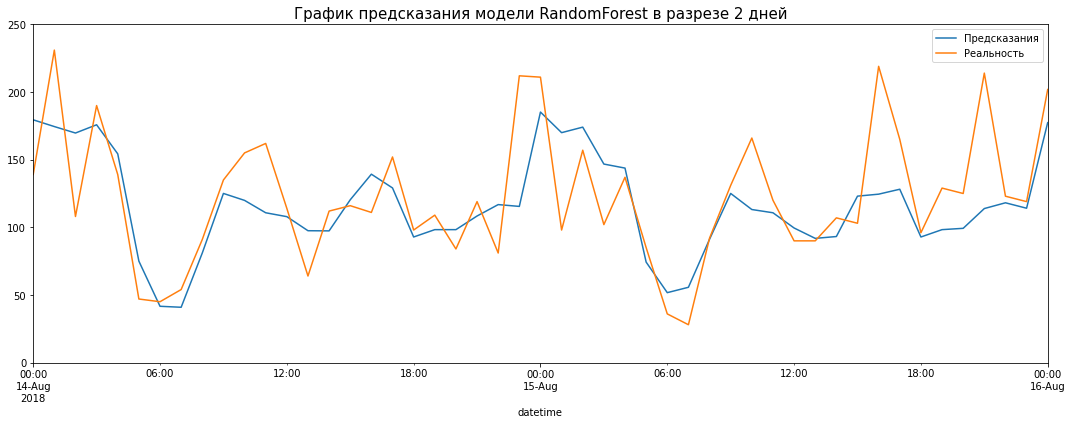

In [50]:
RMSE_forest = pd.Series(forest_grid.predict(features_test), index = target_test.index)
plt.figure(figsize=(15, 6))

plt.title('График предсказания модели RandomForest в разрезе 2 дней', fontsize=15)
RMSE_forest.plot(label = 'Предсказания')
target_test.plot(label = 'Реальность')
plt.xlim(['2018-08-14','2018-08-16'])
plt.ylim([0, 250])
plt.legend()
plt.tight_layout()


Проверим модели на адекватность по среднему значению:

In [51]:
predicted_mean = np.ones(test.shape[0])*train['num_orders'].mean()
rmse_mean = mean_squared_error(target_test, predicted_mean)**0.5
print("Оценка RMSE по среднему значению :", rmse_mean)

Оценка RMSE по среднему значению : 84.6499381993622


Проверим модели на адекватность по последующему значению: 

In [52]:
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = target_test.iloc[-1]
RMSE_previous = mean_squared_error(target_test, pred_previous)**0.5
print("Оценка RMSE по последнему значению:", RMSE_previous )

Оценка RMSE по последнему значению: 59.054503546641314


**ПОСМОТРИМ НА РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ**

In [55]:
result_linear.join([result_forest, result_light, result_cat])

,RMSE_Linear,RandomForest,LightGBM,CatBoost
"Среднее время обучения, сек.",0.004346,0.021059,0.034120,0.781662
Время предсказания сек.,0.002317,0.004488,0.004438,0.001995
RMSE на train,31.366764,27.899592,20.509385,18.245431
RMSE на test,51.194081,47.242779,45.207844,43.776370


## Общий вывод

В ходе работы нам были даны данные, в которых выполнили ресемплинг по часу, подготовили к анализу и посмотрели на тренд, сезонность и пришли к таким выводам, что спрос на такси увеличивается в зависимости от приближения лета и сезона отпусков. 

Присутствует тренд увеличения заказов такси и внутридневная сезонность, связаная с уменьшением количества заказов такси в ночное время и ростом в дневное. В рамках недели пик приходится на пятницу и субботу.


Далее были построены модели для прогнозирования необходимого количества такси на следующий час: линейная регрессия, CatBoost, LightGBM и RandomForest.


Целью стояло подготовить модель с RMSE менее 48.
С данной задачью справились RandomForest, LightGBM, CatBoost, но модель  CatBoost показала лучшие результаты на трейне и тесте, возможно и LightGBM был бы более хорош, подобрав более оптимальные параметры, списывать его со счетов не стоит.


По итогу проведённой работы мы выбрали перспективную модель CatBoost для прогнозирования количества заказов такси на следующий час.